## Nonlinear pulse propagation

Will use parameters from Marc and Alireza's paper[1] to validate the code.

[1]M. Jankowski et al., “Temporal Simultons in Optical Parametric Oscillators,” Phys. Rev. Lett., vol. 120, no. 5, p. 053904, Feb. 2018, doi: 10.1103/PhysRevLett.120.053904.

In [1]:
import numpy as np
from numpy.fft import fft, ifft, fftshift
import matplotlib.pyplot as plt
import time
import scipy
from matplotlib import cm

#This are my libraries
import nlo 
from util import sech

In [2]:
#Change size of plots
plt.rcParams['figure.figsize'] = [10, 5]

## Units
We'll work in the following units:

time = fs <br>
frequency = PHz (1/time) <br>
distance = mm

In [3]:
from scipy.constants import pi, c
c = c*1e-12; #mm/fs, [Freq]=PHz

## Time and Frequency domain windows

In [4]:
NFFT = 2**10 #Fourier size

Tmax = 2000 #(fs) (window will go from -Tmax to Tmax)
t = np.linspace(-Tmax, Tmax, NFFT, endpoint=False)
ts = t[1]-t[0] #Sampling period

print('Sampling Rate =', ts, 'fs')

Sampling Rate = 3.90625 fs


## Signal pulse creation

3.839e-17 fJ
3.839e-17 fJ


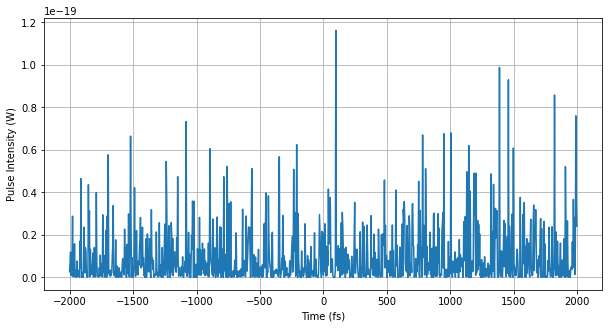

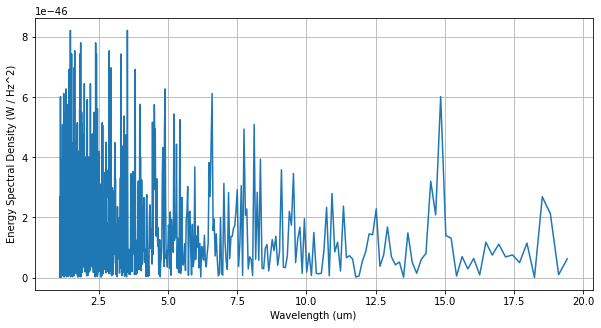

In [5]:
wla = 2.090e-3 #signal wavelength (mm)
noise = 1e-10*np.random.normal(size=NFFT)
signal_in = nlo.pulse(t, noise, wla*1e3)

signal_in.plot_magsq_vs_time()
signal_in.plot_ESD_vs_wavelength()
print(format(signal_in.energy_td()*1e15, '0.3e'), 'fJ')
print(format(signal_in.energy_fd()*1e15, '0.3e'), 'fJ')

## Pump pulse creation

2.000e+00 nJ
2.000e+00 nJ


C:\Users\luish\Documents\Github\Photonics_python_Luis\Modules\nlo.py:59: RuntimeWarning: divide by zero encountered in log10
  self.esd_dB = 10*log10(esd_rel)


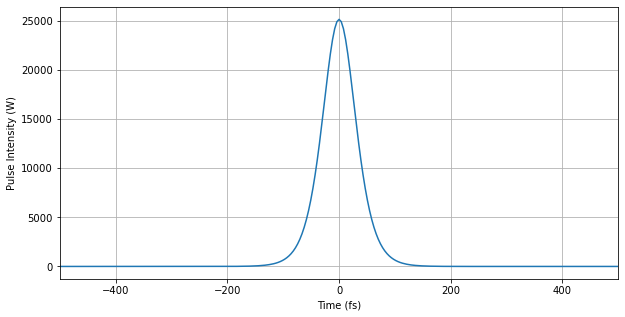

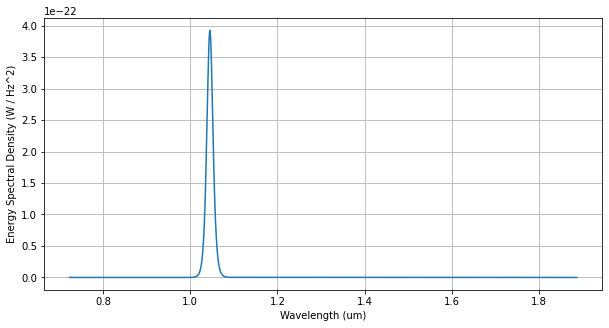

In [6]:
#Parameters
wlb = wla/2 #pump wavelength (mm)
pump_pwr = 0.5 #Average pump power (W)
Tp = 70 #Input pulse width (fs)

#Pulse creation
tau = Tp/1.76
pulse = np.sqrt(0.88*4e6/Tp*pump_pwr)*sech(t/tau)
pump_in = nlo.pulse(t, pulse, wlb*1e3)

pump_in.plot_magsq_vs_time(xlim=[-500,500])
pump_in.plot_ESD_vs_wavelength()
print(format(pump_in.energy_td()*1e9, '0.3e'), 'nJ')
print(format(pump_in.energy_fd()*1e9, '0.3e'), 'nJ')

## Input parameters

In [7]:
#The pulse includes a natural FFT frequency axis
Omega = pump_in.omega*1e-3
print('Freq resolution =', Omega[1]*1e3/(2*pi), 'THz')

#OPO parameters
wa = 2*pi*c/wla #Central angular frequency for pulse "a"
Co_loss = 1-0.65  #Output coupler loss
Ws = 14e-3 #Beam waist of signal (mm)
Nrt = 200 #Round trips

Freq resolution = 0.25 THz


## Feedback Loop

In [8]:
#Cavity dispersion parameters
phi2 = 25
phi3 = 76
phi4 = -13020
phi5 = 983328

#Feedback loop
deltaphi = (phi2/2)*Omega**2 + (phi3/6)*Omega**3 + (phi4/24)*Omega**4 + (phi5/120)*Omega**5
dT = 0 #Detuning in fs
l = c*dT/wlb #Detuning parameter l
phi = pi*l + dT*Omega + deltaphi
fb = np.sqrt(Co_loss)*np.exp(1j*phi)

#Linear element representing this feedback path
fb = nlo.linear_element(fb)  

## Nonlinear element

In [9]:
#Crystal dispersion
alpha_a = 0.00691 #loss for signal in crystal (1/mm)
alpha_b = 0.00691 #loss for pump in crystal (1/mm)
u = 112.778 #Group velocity mismatch (fs/mm)
b2a = -53.64 #second order GVD signal (fs^2/mm)
b3a = 756.14 #third order GVD signal (fs^3/mm)
b4a = -2924.19 #fourth order GVD signal (fs^4/mm)
b2b = 240.92 #second order GVD pump (fs^2/mm)
b3b = 211.285 #second order GVD pump (fs^3/mm)
b4b = -18.3758 #second order GVD pump (fs^4/mm)
deff = 2/pi*16e-9 #effective nonlinear coefficient (mm/V)
na = 2.2333# refractive index at signal
nb = 2.1935# refractive index at pump

#Dispersion functions
Da = alpha_a/2 - 1j*b2a*Omega**2/2 - 1j*b3a*Omega**3/6 - 1j*b4a*Omega**4/24
Db = alpha_b/2 - 1j*u*Omega - 1j*b2b*Omega**2/2 - 1j*b3b*Omega**3/6 - 1j*b4b*Omega**4/24

#Crystal parameters
L = 1 #mm
h = L/50 #Distance step Size

#Nonlinear coupling
nlc = np.sqrt(2*377)*deff*(Omega+wa)/(Ws*na*c*np.sqrt(pi*nb))

crystal = nlo.nonlinear_element(L=L, h=h, Da=Da, Db=Db, nlc=nlc)

## OPO

In [10]:
Nrt = 300
tic = time.time();
signal, pump, signal_evolution, signal_energy_evol, pump_energy_evol = nlo.OPO(signal_in, pump_in, crystal, fb, N=Nrt)
elapsed = time.time() - tic;
print('Time elapsed = ' + str(round(elapsed,5)) + ' seconds')

C:\Users\luish\Documents\Github\Photonics_python_Luis\Modules\nlo.py:86: RuntimeWarning: divide by zero encountered in log10
  self.esd_dB = 10*log10(esd_rel)


Completed roundtrip 50
Completed roundtrip 100
Completed roundtrip 150
Completed roundtrip 200
Completed roundtrip 250
Completed roundtrip 300
Time elapsed = 7.33272 seconds


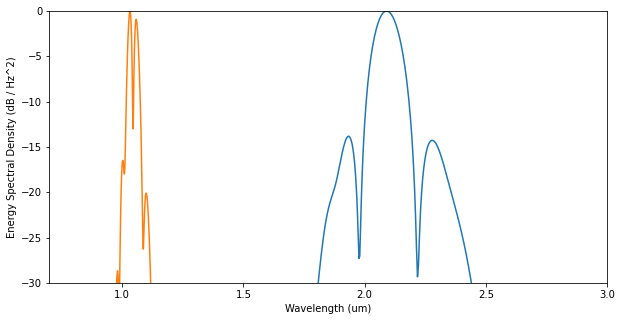

In [11]:
fig = plt.figure(); ax1 = fig.add_subplot(111)
signal.plot_ESD_dB_wavelength(ax1=ax1,xlim=[0.7,3], ylim=[-30,0])
pump.plot_ESD_dB_wavelength(ax1=ax1, xlim=[0.7,3], ylim=[-30,0])

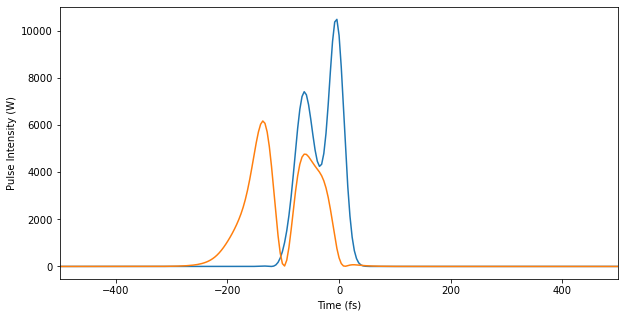

In [12]:
fig = plt.figure(); ax1 = fig.add_subplot(111)
signal.plot_magsq_vs_time(xlim=[-500,500], ax1=ax1)
pump.plot_magsq_vs_time(xlim=[-500,500], ax1=ax1)

(-300.0, 200.0)

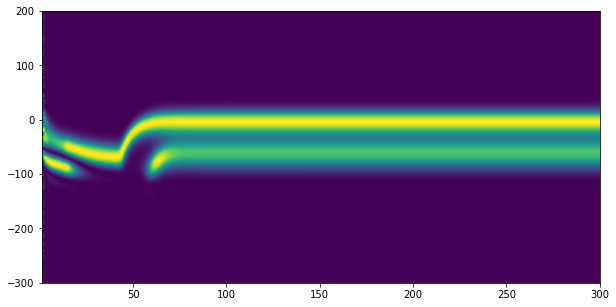

In [13]:
X,Y = np.meshgrid(np.arange(1,Nrt+1), t)
plt.contourf(X, Y, np.transpose(signal_evolution), 100)
plt.ylim([-300,200])
# plt.xlim([0,100])

Now let's look at how the energy of the signal and pump change vs round trips:

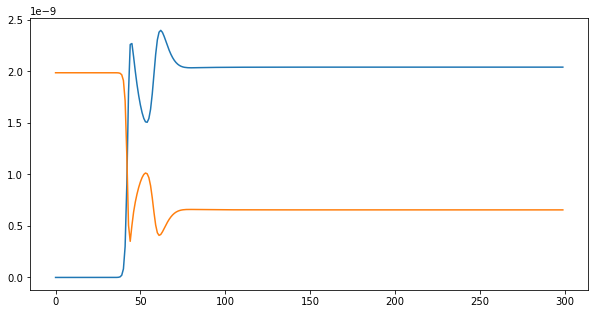

In [14]:
plt.plot(np.arange(Nrt), signal_energy_evol)
plt.plot(np.arange(Nrt), pump_energy_evol)

## Detuning sweep

In [15]:
# dT_array = np.arange(-25,10,1)
# signal = np.empty( dT_array.shape , dtype=object)
# k = 0
# for dT in dT_array:

#     #Feedback loop
#     l = c*dT/wlb #Detuning parameter l
#     phi = pi*l + dT*Omega + deltaphi
#     fb = np.sqrt(Co_loss)*np.exp(1j*phi)

#     #Linear element representing this feedback path
#     fb = nlo.linear_element(fb)
    
#     print('Detuning = %0.2f' %(dT))
#     signal[k], pump, signal_evol, signal_energy, pump_energyl = nlo.OPO(signal_in, pump_in, crystal, fb, N=Nrt)
    
#     k = k+1

In [16]:
# signal[20].plot_ESD()

In [17]:
# plt.plot(fftshift(Omega), fftshift(signal[20].esd))

In [18]:
# signal_spec = np.zeros([Omega.size, dT_array.size])
# fig = plt.figure(); ax1 = fig.add_subplot(111)
# for k in range(dT_array.size):
#     signal_spec[:,k] = fftshift(signal[k].esd)
#     ax1.plot(fftshift(Omega), fftshift(signal[k].esd))

In [19]:
# X,Y = np.meshgrid(fftshift(Omega)*1000, dT_array)
# plt.contourf(X, Y, np.transpose(signal_spec), 100)
# # plt.ylim([-2,2])
# # plt.xlim([-40,40])